In [3]:
import os, importlib, sys, time, h5py

In [4]:
import numpy as np
from scipy import io, linalg, stats, ndimage, signal
from scipy.sparse import diags

In [5]:
import matplotlib.pyplot as plt
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size':12})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino'], 'size':12})
# rc('text', usetex=False)

In [6]:
import ladyns as ldn
import ladyns.inference as inf

In [8]:
save_dir = "../temp/Appendix_C1"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 0. simulate data

In [9]:
dims = [25, 25]
num_rtime = 500
num_trial = 1000

In [10]:
rec_time = [0, 500]

## cross precision

In [11]:
num_blobs = 3

In [12]:
f_beta = 18
cwt_omega = 3
cwt_scale = cwt_omega * 1000 / (2 * f_beta * np.pi)
filter_map = signal.morlet2(num_rtime, cwt_scale, cwt_omega)

In [13]:
ts_sig = [80, 200, 400]
ss_sig = [1250, 1250, 1250]
pbts = [np.exp(-np.square(np.arange(num_rtime) - t)/s)
       for t, s in zip(ts_sig, ss_sig)]

In [14]:
lags = [[0, 30, 30],
        [30, 0, 0]]

## auto precision

In [15]:
alpha = 1.4
f = np.linspace(0, np.pi, num_rtime//2+1)[1:-1]
psd = 1/(f**alpha)

In [16]:
coords_S = [np.array(np.where(np.full((5,5), True))).T for _ in np.arange(2)]
sigmas_S = [0.8, 0.8]
covs_S = [np.exp(-np.sum((cd[:,None,:] - cd[None,:,:])**2,-1)
                 / (2 * sigma**2))
          for cd, sigma in zip(coords_S, sigmas_S)]

## latent direction

In [17]:
ctrs = [[(1, 1), (3, 3), (2, 2)],
        [(3, 3), (1, 1), (2, 2)]]

In [18]:
betas = [[np.exp(-np.sum((cd-ct)**2,-1)/(2*sig**2))
          for ct in ctr]
         for cd, ctr, sig in zip(coords_S, ctrs, sigmas_S)] 

## true factor loadings

In [19]:
fpbts = [
    signal.convolve(pbt, np.abs(signal.convolve(filter_map, filter_map, mode='same')))
    for pbt in pbts
]
betas_true = np.array([
    beta[0] * fpbts[0][num_rtime//2-lag[0]:-num_rtime//2-lag[0]+1:10,None]
    + beta[1] * fpbts[1][num_rtime//2-lag[1]:-num_rtime//2-lag[1]+1:10,None]
    + beta[2] * fpbts[2][num_rtime//2-lag[2]:-num_rtime//2-lag[2]+1:10,None]
    for beta, lag in zip(betas, lags)
])

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Palatino


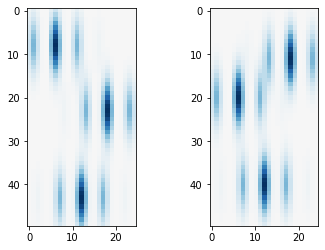

In [20]:
plt.subplot(1,2,1); ldn.imshow(betas_true[0])
plt.subplot(1,2,2); ldn.imshow(betas_true[1])

## simulation function

In [21]:
num_time = num_rtime // 10

In [22]:
def generate_sim(w):
    # generate white noise
    Ws = [np.sqrt(0.5 * psd)[:,None] * 
          np.random.multivariate_normal(np.zeros(d), cov, 
                size=(num_trial, num_rtime//2-1))
          for d, cov in zip(dims, covs_S)]
    RZs = [np.concatenate([
           np.random.multivariate_normal(np.zeros(d), cov, 
               size=(num_trial,1)), 
           W, 
           np.random.multivariate_normal(np.zeros(d), cov, 
               size=(num_trial,1)), 
           np.flip(W, axis=1)], axis=1)
           for d, W, cov in zip(dims, Ws, covs_S)]
    Ws = [np.sqrt(0.5 * psd)[:,None] * 
          np.random.multivariate_normal(np.zeros(d), cov, 
                size=(num_trial, num_rtime//2-1))
          for d, cov in zip(dims, covs_S)]
    IZs = [np.concatenate([
           np.zeros((num_trial,1,d)), 
           W, 
           np.zeros((num_trial,1,d)), 
           np.flip(W, axis=1)], axis=1)
           for W, cov, d in zip(Ws, covs_S, dims)]
    etas = [np.fft.irfft(RZ+ 1j*IZ, num_rtime, axis=1)
            for RZ, IZ in zip(RZs, IZs)]
#     sys.stdout.write("noise generated \n")
#     sys.stdout.flush()
    
    # generate signals
    cwt_omega = 3
    cwt_scale = cwt_omega * 1000 / (2 * f_beta * np.pi)
    filter_map = signal.morlet2(num_rtime, cwt_scale, cwt_omega)
    
    Ws = [np.random.normal(scale=pbt, size=(num_trial,num_rtime))
          for pbt in pbts]
    sigs =  [signal.convolve(W, filter_map[None,:])
             for W in Ws]
#     sys.stdout.write("signal generated \n")
#     sys.stdout.flush()
    
    # generate data
    obss = [eta + np.exp(2j*np.pi*np.random.uniform(size=1000)[:,None,None]) * w * beta[0] * sigs[0][:,num_rtime//2-lag[0]:-num_rtime//2-lag[0]+1,None]
                + np.exp(2j*np.pi*np.random.uniform(size=1000)[:,None,None]) * w * beta[1] * sigs[1][:,num_rtime//2-lag[1]:-num_rtime//2-lag[1]+1,None]
                + np.exp(2j*np.pi*np.random.uniform(size=1000)[:,None,None]) * w * beta[2] * sigs[2][:,num_rtime//2-lag[2]:-num_rtime//2-lag[2]+1,None]
            for eta, beta, lag in zip(etas, betas, lags)]
#     sys.stdout.write("observation generated \n")
#     sys.stdout.flush()
    
    return obss

In [23]:
def preprocess(data_raw):
    cwt_omega = 3 
    cwt_scale = cwt_omega * 1000 / (2 * f_beta * np.pi)
    filter_map = signal.morlet2(num_rtime, cwt_scale, cwt_omega)
    
    data = [np.zeros((num_time, d , num_trial), dtype=np.cdouble)
            for d in dims]
    
    for l, d in enumerate(dims):
        for i in np.arange(d):
#             sys.stdout.write("CWT on channel %d-%d \n"%(l, i))
#             sys.stdout.flush()
            data[l][:,i,:] = (signal.convolve(data_raw[l][:,:,i], 
                filter_map[None,:], mode='same')[:,::10]).T
            
    return data

## test

In [26]:
data_raw = generate_sim(np.sqrt(0.006))

In [27]:
data = preprocess(data_raw)

In [28]:
weight_true = [
    btrue[:,None,:] 
    @ np.array([np.linalg.inv(np.cov(d)) for d in np.abs(dat)])
    for dat, btrue in zip(data, betas_true)]

In [29]:
Sigma_true = np.corrcoef(np.concatenate([ np.squeeze(
    btrue[:,None,:] 
    @ np.array([np.linalg.inv(np.cov(d)) for d in np.abs(dat)])
    @ np.abs(dat)) for dat, btrue in zip(data, betas_true)], 0))

Omega_true = np.linalg.inv(Sigma_true + lambda_diag * np.eye(2*num_time))

Coh_true = np.abs(np.corrcoef(np.concatenate([ np.squeeze(
    btrue[:,None,:] 
    @ np.array([np.linalg.inv(np.cov(d)) for d in np.abs(dat)])
    @ dat) for dat, btrue in zip(data, betas_true)])))

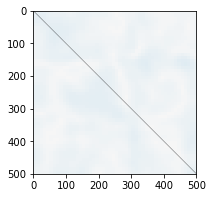

In [30]:
plt.figure(figsize=(3,3))
ldn.imshow(Coh_true[:num_time,num_time:], time=rec_time, identity=True, vmax=0.6)

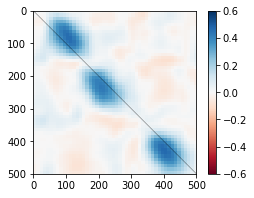

In [31]:
plt.figure(figsize=(4,3))
ldn.imshow(Sigma_true[:num_time,num_time:], time=rec_time, identity=True, vmax=0.6)
plt.colorbar()

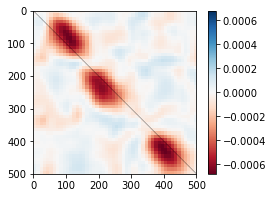

In [32]:
plt.figure(figsize=(4,3))
ldn.imshow(Omega_true[:num_time,num_time:], time=rec_time, identity=True)
plt.colorbar()

# 1. iterate simulation

In [33]:
num_sim = 200

In [34]:
Sigmas_true = np.zeros([num_sim, 2*num_time, 2*num_time])
Omegas_true = np.zeros([num_sim, 2*num_time, 2*num_time])
Cohs_true = np.zeros([num_sim, 2*num_time, 2*num_time], dtype=np.cdouble)
for iter_sim in range(num_sim): 
    start_sim = time.time()
    
    # data simulation
    obss = generate_sim(np.sqrt(0.006))
    sys.__stdout__.write("%d-th data generation finished, lapse: %.3fsec.\n"
                         %(iter_sim+1, time.time()-start_sim))
    sys.__stdout__.flush()

    data = preprocess(obss)
    sys.__stdout__.write("%d-th preprocess finished, lapse: %.3fsec.\n"
                         %(iter_sim+1, time.time()-start_sim))
    sys.__stdout__.flush()
    
    Sigmas_true[iter_sim] = np.corrcoef(np.concatenate([ np.squeeze(
        btrue[:,None,:] 
        @ np.array([np.linalg.inv(np.cov(d)) for d in np.abs(dat)])
        @ np.abs(dat)) for dat, btrue in zip(data, betas_true)], 0))

    Omegas_true[iter_sim] = np.linalg.inv(Sigmas_true[iter_sim] + lambda_diag * np.eye(2*num_time))

    Cohs_true[iter_sim] = np.corrcoef(np.concatenate([ np.squeeze(
        btrue[:,None,:] 
        @ np.array([np.linalg.inv(np.cov(d)) for d in np.abs(dat)])
        @ dat) for dat, btrue in zip(data, betas_true)]))

1-th data generation finished, lapse: 2.365sec.
1-th preprocess finished, lapse: 4.177sec.
2-th data generation finished, lapse: 2.350sec.
2-th preprocess finished, lapse: 4.158sec.
3-th data generation finished, lapse: 2.348sec.
3-th preprocess finished, lapse: 4.161sec.
4-th data generation finished, lapse: 2.320sec.
4-th preprocess finished, lapse: 4.120sec.
5-th data generation finished, lapse: 2.348sec.
5-th preprocess finished, lapse: 4.161sec.
6-th data generation finished, lapse: 2.320sec.
6-th preprocess finished, lapse: 4.123sec.
7-th data generation finished, lapse: 2.351sec.
7-th preprocess finished, lapse: 4.164sec.
8-th data generation finished, lapse: 2.319sec.
8-th preprocess finished, lapse: 4.126sec.
9-th data generation finished, lapse: 2.348sec.
9-th preprocess finished, lapse: 4.158sec.
10-th data generation finished, lapse: 2.322sec.
10-th preprocess finished, lapse: 4.120sec.
11-th data generation finished, lapse: 2.348sec.
11-th preprocess finished, lapse: 4.154

89-th preprocess finished, lapse: 4.187sec.
90-th data generation finished, lapse: 2.331sec.
90-th preprocess finished, lapse: 4.143sec.
91-th data generation finished, lapse: 2.350sec.
91-th preprocess finished, lapse: 4.163sec.
92-th data generation finished, lapse: 2.317sec.
92-th preprocess finished, lapse: 4.121sec.
93-th data generation finished, lapse: 2.354sec.
93-th preprocess finished, lapse: 4.169sec.
94-th data generation finished, lapse: 2.318sec.
94-th preprocess finished, lapse: 4.124sec.
95-th data generation finished, lapse: 2.351sec.
95-th preprocess finished, lapse: 4.162sec.
96-th data generation finished, lapse: 2.318sec.
96-th preprocess finished, lapse: 4.123sec.
97-th data generation finished, lapse: 2.385sec.
97-th preprocess finished, lapse: 4.226sec.
98-th data generation finished, lapse: 2.354sec.
98-th preprocess finished, lapse: 4.187sec.
99-th data generation finished, lapse: 2.405sec.
99-th preprocess finished, lapse: 4.245sec.
100-th data generation fin

176-th data generation finished, lapse: 2.645sec.
176-th preprocess finished, lapse: 4.537sec.
177-th data generation finished, lapse: 2.557sec.
177-th preprocess finished, lapse: 4.445sec.
178-th data generation finished, lapse: 2.355sec.
178-th preprocess finished, lapse: 4.231sec.
179-th data generation finished, lapse: 2.418sec.
179-th preprocess finished, lapse: 4.302sec.
180-th data generation finished, lapse: 2.480sec.
180-th preprocess finished, lapse: 4.358sec.
181-th data generation finished, lapse: 2.521sec.
181-th preprocess finished, lapse: 4.401sec.
182-th data generation finished, lapse: 2.385sec.
182-th preprocess finished, lapse: 4.253sec.
183-th data generation finished, lapse: 2.644sec.
183-th preprocess finished, lapse: 4.569sec.
184-th data generation finished, lapse: 2.535sec.
184-th preprocess finished, lapse: 4.397sec.
185-th data generation finished, lapse: 2.419sec.
185-th preprocess finished, lapse: 4.302sec.
186-th data generation finished, lapse: 2.759sec.


## plots

Text(0, 0.5, 'series 1 at time $t$ ms')

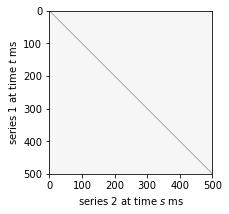

In [35]:
plt.figure(figsize=(3,3))
ldn.imshow(np.abs(np.mean(Cohs_true, 0))[:num_time,num_time:], time=[0,500], identity=True, vmax = 0.6)
plt.xlabel(r"series 2 at time $s$ ms"); plt.ylabel(r"series 1 at time $t$ ms")

([], [])

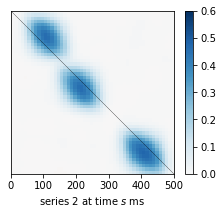

In [44]:
plt.figure(figsize=(4,3))
ldn.imshow(np.mean(Sigmas_true, 0)[:num_time,num_time:], time=[0,500], identity=True, vmax=0.6)
plt.xlabel(r"series 2 at time $s$ ms"); # plt.ylabel(r"series 1 at time $t$ ms")
cbar = plt.colorbar()
cbar.ax.set_ylim(0,0.6)#; cbar.formatter.set_powerlimits((0, 0))
plt.yticks([],[])

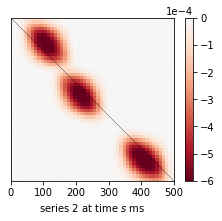

In [42]:
plt.figure(figsize=(4,3))
ldn.imshow(np.mean(Omegas_true, 0)[:num_time,num_time:], vmax=0.0006, time=[0,500], identity=True)
plt.xlabel(r"series 2 at time $s$ ms"); # plt.ylabel(r"series 1 at time $t$ ms")
plt.yticks([],[])
cbar = plt.colorbar()
cbar.ax.set_ylim(-6e-4,0); cbar.formatter.set_powerlimits((0, 0))